[tutorial](https://www.youtube.com/watch?v=5fHngyN8Qhw)

In [2]:
from keras.layers import Dense,Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam
import numpy as np

In [3]:
class ReplayBuffer(object):
    def __init__(self,max_size,input_shape,n_actions,discrete=False):
        self.mem_size=max_size
        self.mem_cntr=0
        self.discrete=discrete

        self.state_memory=np.zeros((self.mem_size,input_shape))
        self.new_state_memory=np.zeros((self.mem_size,input_shape))

        dtype=np.int8 if self.discrete else np.float32
        self.action_memory = np.zeros((self.mem_size,n_actions),dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size,dtype=np.float32)

    def store_transition(self,state,action,reward,state_,done):
        # when end of memory reached, go back to begining
        index= self.mem_cntr % self.mem_size
        self.state_memory[index]=state
        self.new_state_memory[index]=state_
        self.reward_memory[index]=reward
        # done = false, when episode is over you want terminal memory to be 0 ?
        self.terminal_memory[index]= 1-int(done)
        if self.discrete:
            # one hot encoding
            actions= np.zeros(self.action_memory.shape[1])
            actions[action]=1.0
            self.action_memory[index]=actions
        else:
            self.action_memory[index]=action
        self.mem_cntr+=1

    # you want to feed batch size to network, not entire memory
    def sample_buffer(self,batch_size):
        # value to sample up to
        max_mem = min(self.mem_cntr,self.mem_size)
        # batch size = shape
        batch = np.random.choice(max_mem,batch_size)

        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        rewards = self.reward_memory[batch]
        actions = self.action_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_,terminal

In [4]:
def build_dqn(lr,n_actions,input_dims,fcl_dims,fc2_dims):
    # fcl_dims, fc2_dims are size of dense layers
    model = Sequential([
        Dense(fcl_dims,input_shape=(input_dims, )),
        Activation('relu'),
        Dense(fc2_dims),
        Activation('relu'),
        Dense(n_actions)])
    model.compile(optimizer=Adam(lr=lr),loss='mse')
    return model

In [5]:
class Agent(object): 
    # alhpa = learning rate
    # gamma = discount factor for future rewards
    # epsilon = random factor, sometimes take 'greedy' best known actions, sometimes take random action (explore/exploit)
    def __init__(self,alpha,gamma,n_actions,epsilon, batch_size,input_dims,epsilon_dec=0.996,epsilon_end=0.01,mem_size=1000000,fname='dqn_model.h5'):
        self.action_space=[i for i in range(n_actions)]
        self.gamma=gamma
        self.epsilon=epsilon
        self.epsilon_dec=epsilon_dec
        self.epsilon_min = epsilon_end
        self.batch_size=batch_size
        self.model_file=fname

        self.memory=ReplayBuffer(mem_size,input_dims,n_actions,discrete=True)
        self.q_eval=build_dqn(alpha,n_actions,input_dims,256,256)

    def remember(self,state,action,reward,new_state,done):
        self.memory.store_transition(state,action,reward,new_state,done)

    def choose_action(self,state):
        state = state[np.newaxis,:]
        rand = np.random.random()
        if rand<self.epsilon:
            # random action
            action = np.random.choice(self.action_space)
        else:
            # best action
            actions=self.q_eval.predict(state)
            action = np.argmax(actions)
        return action
    def learn(self):
        # temporal difference learning = learn on every step
        # fill up batch size before starting to learn
        if self.memory.mem_cntr < self.batch_size:
            return 
        
        # non sequential sampling, dont get hung up
        state,action,reward,new_state,done=\
            self.memory.sample_buffer(self.batch_size)

        # one hot back to integer
        action_values = np.array(self.action_space,dtype=np.int8)
        action_indices = np.dot(action,action_values)

        ## predict next states
        q_eval = self.q_eval.predict(state)
        q_next = self.q_eval.predict(new_state)

        q_target = q_eval.copy()

        batch_index = np.arange(self.batch_size,dtype=np.int32)

        q_target[batch_index,action_indices] = reward + \
            self.gamma*np.max(q_next,axis=1)*done
        
        # learning operation, q_target is what we are shooting for 
        # (best possible action)
        _ = self.q_eval.fit(state,q_target,verbose=0)

        self.epsilon = self.epsilon*self.epsilon_dec if \
            self.epsilon>self.epsilon_min else self.epsilon_min
    def save_model(self):
        self.q_eval.save(self.model_file)

    def load_model(self):
        self.q_eval=load_model(self.model_file)

## environment

In [6]:
from kaggle_environments import make, evaluate
from gym import spaces

class ConnectFourGym:
    def __init__(self, agent2="random"):
        ks_env = make("connectx", debug=True)
        self.env = ks_env.train([None, agent2])
        self.rows = ks_env.configuration.rows
        self.columns = ks_env.configuration.columns
        self.action_space = spaces.Discrete(self.columns)
        self.observation_space = spaces.Box(low=0, high=2, 
                                            shape=(self.rows,self.columns,1), dtype=np.int)
        # Tuple corresponding to the min and max possible rewards
        self.reward_range = (-10, 1)
        # StableBaselines throws error if these are not defined
        self.spec = None
        self.metadata = None
    def reset(self):
        self.obs = self.env.reset()
        return np.array(self.obs['board'])
    def change_reward(self, old_reward, done):
        if old_reward == 1: # The agent won the game
            return 1
        elif done: # The opponent won the game
            return -1
        else: # Reward 1/42
            return 1/(self.rows*self.columns)
    def step(self, action):
        # Check if agent's move is valid
        is_valid = (self.obs['board'][int(action)] == 0)
        if is_valid: # Play the move
            self.obs, old_reward, done, _ = self.env.step(int(action))
            reward = self.change_reward(old_reward, done)
        else: # End the game and penalize agent
            reward, done, _ = -10, True, {}
        return np.array(self.obs['board']), reward, done, _

        # np.array(self.obs['board']).reshape(self.rows,self.columns,1)

Loading environment football failed: No module named 'gfootball'


## play games / training

300 times against random opponent

300 times against agent that trained 300 times with random

### train against random 

In [6]:
env = ConnectFourGym(agent2="random")
n_games=300
agent= Agent(gamma=0.99,epsilon=1.0,alpha=0.0005,input_dims=42, n_actions=7,mem_size=1000000,batch_size=64,epsilon_end=0.01,fname='agent1.h5')
scores=[]
eps_history=[]

In [7]:
for i in range(n_games):
    done=False
    score=0
    observation=env.reset()
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score+=reward
        agent.remember(observation,action,reward,observation_,done)
        observation = observation_
        agent.learn()
    eps_history.append(agent.epsilon)
    scores.append(score)

    # save model every 10 games
    if i%10 == 0 and i>0:
        agent.save_model()

        # show average score of last 100 games
        avg_score = np.mean(scores[max(0,i-100):(i+1)])
        print(f'episode {i} score {round(score,2)}, average score {round(avg_score,2)}')
        

episode 10 score -0.74, average score -1.24
episode 20 score 1.26, average score -2.85
episode 30 score 1.12, average score -2.23
episode 40 score -0.81, average score -2.12
episode 50 score -9.67, average score -1.8
episode 60 score 1.12, average score -1.59
episode 70 score 1.24, average score -1.5
episode 80 score 1.21, average score -1.24
episode 90 score 1.36, average score -1.06
episode 100 score 1.21, average score -0.88
episode 110 score 1.19, average score -0.65
episode 120 score -0.67, average score -0.15
episode 130 score 1.24, average score 0.0
episode 140 score 1.33, average score 0.26
episode 150 score 1.1, average score 0.28
episode 160 score -0.81, average score 0.48
episode 170 score 1.26, average score 0.63
episode 180 score 1.29, average score 0.51
episode 190 score -0.71, average score 0.51
episode 200 score 1.31, average score 0.49
episode 210 score -0.79, average score 0.44
episode 220 score 1.1, average score 0.47
episode 230 score 1.29, average score 0.45
episod

(-2.0, 2.0)

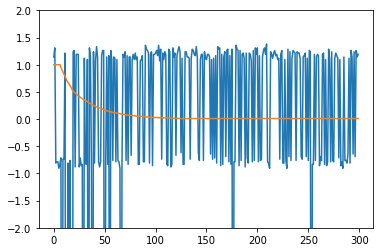

In [8]:
import matplotlib.pyplot as plt

plt.plot(range(len(scores)),scores)
plt.plot(range(len(eps_history)),eps_history)
plt.ylim(-2,2)

### train with agent1

In [9]:
model1= Agent(gamma=0.99,epsilon=0,alpha=0.0005,input_dims=42, n_actions=7,mem_size=1000000,batch_size=64,epsilon_end=0.01,fname='agent1.h5')
model1.load_model()
def agent1(obs,config):
    return int(model1.choose_action(np.array(obs['board'])))

In [10]:
env = ConnectFourGym(agent2=agent1)
n_games = 300
agent = Agent(gamma=0.99,epsilon=1.0,alpha=0.0005,input_dims=42, n_actions=7,mem_size=1000000,batch_size=64,epsilon_end=0.01,
fname='agent2.h5')
scores=[]
eps_history=[]

In [11]:
for i in range(n_games):
    done=False
    score=0
    observation=env.reset()
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score+=reward
        agent.remember(observation,action,reward,observation_,done)
        observation = observation_
        agent.learn()
    eps_history.append(agent.epsilon)
    scores.append(score)

    # save model every 10 games
    if i%10 == 0 and i>0:
        agent.save_model()

        # show average score of last 100 games
        avg_score = np.mean(scores[max(0,i-100):(i+1)])
        print(f'episode {i} score {round(score,2)}, average score {round(avg_score,2)}')

episode 10 score -9.74, average score -1.32
Invalid Action: Invalid column: 3
episode 20 score -0.88, average score -1.21
episode 30 score -0.9, average score -1.06
episode 40 score 1.26, average score -0.98
episode 50 score -0.79, average score -1.0
episode 60 score -0.74, average score -1.05
episode 70 score 1.17, average score -0.76
episode 80 score -0.71, average score -0.76
episode 90 score 1.17, average score -0.75
episode 100 score 1.21, average score -0.73
episode 110 score -0.74, average score -0.65
episode 120 score -0.86, average score -0.46
episode 130 score 1.12, average score -0.37
episode 140 score -0.79, average score -0.39
episode 150 score 1.24, average score -0.31
episode 160 score 1.24, average score -0.22
episode 170 score 1.21, average score -0.23
episode 180 score 1.21, average score -0.16
episode 190 score -0.9, average score -0.01
episode 200 score 1.14, average score 0.11
episode 210 score 1.29, average score 0.17
episode 220 score 1.26, average score 0.12
epi

(-2.0, 2.0)

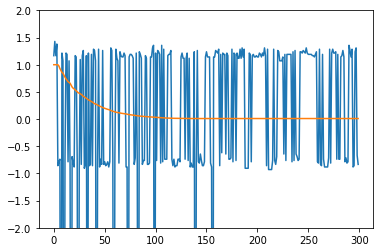

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(len(scores)),scores)
plt.plot(range(len(eps_history)),eps_history)
plt.ylim(-2,2)


## test agent

In [7]:
from kaggle_environments import make, evaluate
import numpy as np

# Create the game environment
# Set debug=True to see the errors if your agent refuses to run
env = make("connectx", debug=True)

In [8]:
model2 = Agent(gamma=0.99,epsilon=0,alpha=0.0005,input_dims=42, n_actions=7,mem_size=1000000,batch_size=64,epsilon_end=0.01,
fname='agent2.h5')
model2.load_model()
def agent2(obs,config):
    return int(model2.choose_action(np.array(obs['board'])))

In [11]:
env.run(['random',agent2])

# Show the game
env.render(mode="ipython")

In [16]:
def get_win_percentages(agent1, agent2, n_rounds=100):
    # Use default Connect Four setup
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    # Agent 1 goes first (roughly) half the time          
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    # Agent 2 goes first (roughly) half the time      
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))

In [17]:
get_win_percentages(agent1=agent1, agent2=agent2)

Agent 1 Win Percentage: 0.0
Agent 2 Win Percentage: 1.0
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


In [18]:
get_win_percentages(agent1="random", agent2=agent2)

Agent 1 Win Percentage: 0.4
Agent 2 Win Percentage: 0.59
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 1


In [19]:
get_win_percentages(agent1="negamax", agent2=agent2)

Agent 1 Win Percentage: 0.89
Agent 2 Win Percentage: 0.04
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 6


## play yourself against agent

In [18]:
env = make("connectx", debug=True)
from IPython.display import clear_output

def agent_me(obs,config):
    env.render(mode="ipython")
    turn = input("Enter turn (0-6):")
    clear_output()
    return int(turn)

In [20]:
env.run([agent2,agent_me])
env.render(mode="ipython")